# Project: Airbnb Seattle Analysis and Prediction

In this project, I wanggle and analyze the open data from Airbnb Seattle to to answer the following 4 questions: 


1) How does the occupancy rate change during the record window?

2) How does the price change during the record window?

3) Are the trends of average price and occupancy rate the same?

4) Using machine learning technique to predict the listing prices.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

## Step 0: Load the Data

There are four files associated with this project (not including this one):

- `listings.csv`
- `calendar.csv`

In [2]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

## Step 1: How does the occupancy rate change during the record window?

### Step 1.1 : Preprocessing

The infomation of the dataset **calendar** is checked. The dataframe  that describes the occupation state everyday is created from **calendar**. The data types of the features are corrected.

In [3]:
# Check the structure of the data 
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [4]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
calendar.iloc[-1,:]

listing_id      10208623
date          2017-01-02
available              f
price                NaN
Name: 1393569, dtype: object

**Observation:** There are some missing values in the column 'price'. When the listing is not available (occupied), the price is NaN. The record window of the dataset is from 2016-01-04 to 2017-01-02. The avaiability of each listing is represented by strings 't' and 'f' instread of boolean variables. 

**Action:** Replace the strings by boolean variables. Since we care about the occupancy rate, the state should be converted from 'available' to 'occupied'. 

In [6]:
# create new dataframe
occupy =  calendar[['date','available']]
occupy['occupied'] = occupy['available'].apply(lambda x: x== 'f')
occupy.drop('available',axis=1, inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
#change the data type of date
occupy.set_index('date')
occupy.index = pd.to_datetime(occupy.date)
occupy.drop('date',axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [8]:
# check the dataframe
occupy.head()

,occupied
date,
2016-01-04,False
2016-01-05,False
2016-01-06,True
2016-01-07,True
2016-01-08,True


### Step 1.2: The amount of listings in each day

Before the analsis of occupancy rate, the number of listings in each day is checked.

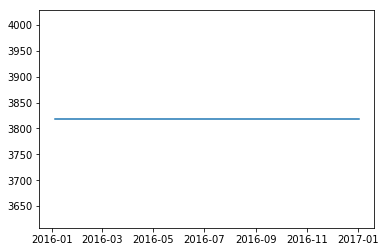

In [9]:
supply = occupy.resample('D').count()
plt.plot(supply['occupied']);

In [10]:
supply.head()

,occupied
date,
2016-01-04,3818
2016-01-05,3818
2016-01-06,3818
2016-01-07,3818
2016-01-08,3818


**Observation:** The everyday number of listings is a constant. It implies that the dataset only contains a part of the data in seattle, which does not show the supply in the market. 


### Step 1.3: The trend of the occupancy rate

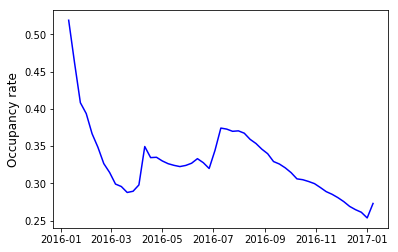

In [11]:
#calculate the average occupancy rate everyweek
occupied_r = occupy.resample('W').mean()
#sketch the trend
ax1 = plt.plot(occupied_r['occupied'], color = 'b')
plt.ylabel('Occupancy rate', fontsize=12);

**Observation:** The occupancy rate generally declines during 2016. It increases at the second quarter to a small extent but keeps dropping to the end of the year. The occupancy rate decreases from over 0.5 to around 0.25. 

## Step 2: How does the price change during the record window?

### Step 2.1 : Preprocessing

As mentioned in the last section, there are some missing values in price when the listing are not available. It makes sense that the price is not necessary to be showed when the listing is not available. Meanwhile, other available listings' prices indicate the market status. These missing values are all removed while the information is not lost. 

The original data type of price is not numeric which is converted in this section.

In [12]:
#remove missing values
calendar_clean = calendar.dropna()
calendar_clean.drop(['available'],axis=1,inplace=True)

#convert data type of price to numeric
calendar_clean['price']=calendar_clean['price'].apply(lambda x: float(x.strip('$').replace(',','')))
calendar_clean['listing_id']=calendar_clean['listing_id'].astype(str)

#change the data type of date
calendar_clean.index = pd.to_datetime(calendar_clean.date)
calendar_clean.drop('date',axis = 1, inplace=True)

#check the conversion
calendar_clean.info()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 934542 entries, 2016-01-04 to 2016-01-12
Data columns (total 2 columns):
listing_id    934542 non-null object
price         934542 non-null float64
dtypes: float64(1), object(1)
memory usage: 21.4+ MB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


### Step 2.2: The trend of the price

The average price everyweek is calculated and sketched.

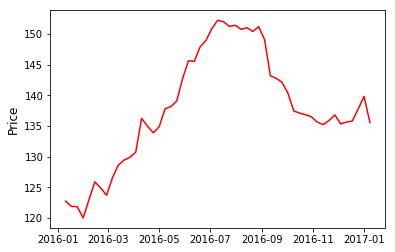

In [13]:
#calculate the average price everyweek
price_mean = calendar_clean.resample('W').mean()

#sketch the trend
ax2=plt.plot(price_mean, color = 'r')
plt.ylabel('Price', fontsize=12);


**Observation:** The average price first increases from around 120 to 150. Then, it fluctuates and falls suddenly after September. At the end of the year, the price is around 135.  

## Step 3: Are the trends of average price and occupancy rate the same?
In this section, the plots in the above sections are merged for clear observation and comparison.

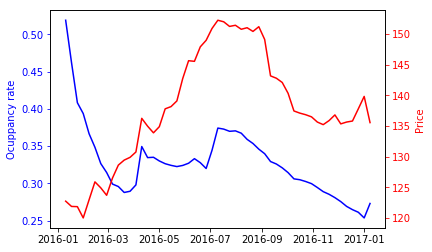

In [14]:
fig, axes1= plt.subplots()
axes2 = axes1.twinx()
axes1.plot(occupied_r['occupied'],'b')
axes2.plot(price_mean, 'r')

axes1.set_ylabel('Ocuppancy rate', color='b');
axes2.set_ylabel('Price', color='r');

axes1.tick_params(axis='y', colors='b')
axes2.tick_params(axis='y', colors='r')

**Observation:** Usually, when the occupancy rate is high, the renting cost is expensive. However, the trends of the occupancy rate and the price in Airbnb Seattle are not completely the same during 2016. In the first quater, the occupancy rate drops largely from over 0.5 to below 0.3, while the price increases with slight fluctuation. Then, The price keeps rising and reaches the peak in July. During this time, the occupancy rate slightly increases and remains stable from May to June then suddenly rises in July. For price, it remains the highest level around two months but sharply declines after September. The tendency of occupancy rate follows the similar step but it drops earlier. After the decrease, the price fluctuates at the level of 135. Although the price falls down, the occupancy rate does not recover. At the end of 2016, the occupancy rate drops to the bottom at 0.25. 

## Step 4: Predcting the price
###   Step 4.1: Preprocessing
####     step 4.1.1 remove missing values

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

**Obeservation:** Besides price, 91 features are recorded in this dataset. But not all of them are related to price.

**Action:** Select the relevant features and create a new dataframe. 

In [16]:
#create new dataframe fro price predction
df = listings[['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_group_cleansed', 
               'property_type', 'room_type', 'accommodates','bathrooms', 'bedrooms','beds','bed_type', 'square_feet','price', 'guests_included', 'number_of_reviews',
              'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
              'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'reviews_per_month']]

In [17]:
def col_nan(df):
    """visualize the missing values propotion in each column.
    df -- dataframe
    """
    nan_prop = df.isnull().sum()/df.shape[0]
    plt.figure(figsize=(10,6));
    plt.bar(nan_prop.index,nan_prop);
    plt.xticks(rotation='vertical');

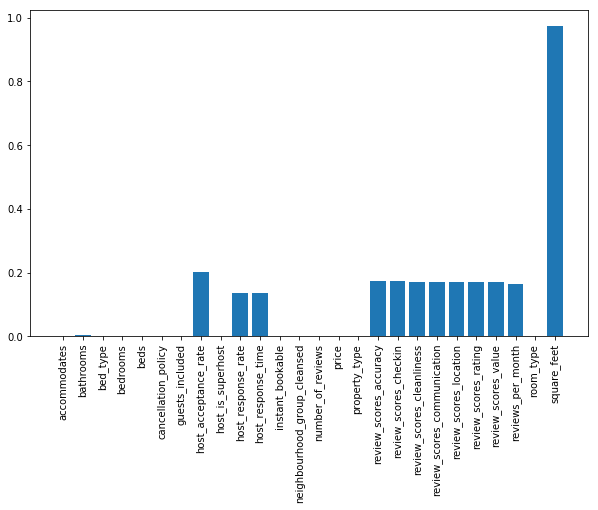

In [18]:
#check the proportion of the missing values in each column
col_nan(df)

In [19]:
def remove_nan(df):
    """remove the columns whose numbers of missing values are outliers.
    df -- dataframe 
    """
    nan_prop = df.isnull().sum()/df.shape[0]
    IQR = nan_prop.quantile(0.75) - nan_prop.quantile(0.25)
    #remove the columns of which the misiing value proportion is outliers.
    nan_prop = nan_prop[~(nan_prop > (nan_prop.quantile(0.75) + 1.5*IQR))]
    cols = list(nan_prop.index)
    df = df[df.columns.intersection(cols)]
    #remove the residual missing values
    df_wona = df.dropna()
    return df_wona

In [20]:
df_wona = remove_nan(df)

In [21]:
#check the processed dataframe
df_wona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2655 entries, 0 to 3814
Data columns (total 25 columns):
host_response_time              2655 non-null object
host_response_rate              2655 non-null object
host_acceptance_rate            2655 non-null object
host_is_superhost               2655 non-null object
neighbourhood_group_cleansed    2655 non-null object
property_type                   2655 non-null object
room_type                       2655 non-null object
accommodates                    2655 non-null int64
bathrooms                       2655 non-null float64
bedrooms                        2655 non-null float64
beds                            2655 non-null float64
bed_type                        2655 non-null object
price                           2655 non-null object
guests_included                 2655 non-null int64
number_of_reviews               2655 non-null int64
review_scores_rating            2655 non-null float64
review_scores_accuracy          2655 non-nul

**Observation:** All missing values have been removed. There are some nonnumerical features that should be further processed. However, some of them represent percentage, such as response rate and acceptance rate.  

**Action:** Normalize the numerical features. Check the values of the nonnumerical features. 

#### step 4.1.2 Feature normalization

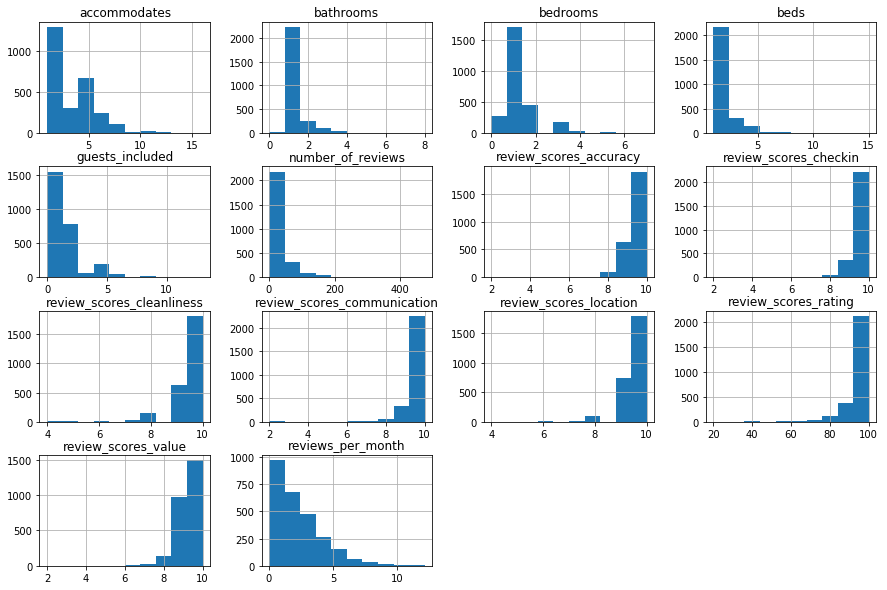

In [22]:
#select the numerical columns
num_cols = df_wona.select_dtypes(exclude=['object']).columns
df_num = df_wona[num_cols]
#visualize the distribution of these features
df_num.hist(figsize=(15,10));

**Observation:** All the distributions are not Guassian distribution. Besides 'number_of_reviews', each feature contains the values of the same order of magnitude. 

**Action:** 'number_of_reviews' should be applied log-transfromation. Then, apply MinMaxScaler for normalization to all the numerical features.

In [23]:
#log-transformation
df_num['number_of_reviews']=df_num['number_of_reviews'].apply(lambda x: np.log(x + 1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
df_num_scal = pd.DataFrame(data = df_num)
scaler = MinMaxScaler()
df_num_scal[df_num.columns] = scaler.fit_transform(df_num[df_num.columns])
df_num_scal.head()

,accommodates,bathrooms,bedrooms,beds,guests_included,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,0.200000,0.1250,0.142857,0.000000,0.153846,0.849040,0.9375,1.0,1.0,1.0,1.0,0.833333,1.0,0.333333
1,0.200000,0.1250,0.142857,0.000000,0.076923,0.565073,0.9500,1.0,1.0,1.0,1.0,1.000000,1.0,0.119637
2,0.666667,0.5625,0.714286,0.428571,0.769231,0.429854,0.9625,1.0,1.0,1.0,1.0,1.000000,1.0,0.092409
6,0.066667,0.1250,0.142857,0.000000,0.076923,0.618700,0.9875,1.0,1.0,1.0,1.0,1.000000,1.0,0.200495
7,0.066667,0.1250,0.142857,0.000000,0.076923,0.816412,0.9625,1.0,1.0,1.0,1.0,0.833333,1.0,0.387789


In [25]:

df_wona.drop(num_cols,axis=1,inplace=True)
df_wona = pd.merge(df_wona,df_num_scal, left_index=True, right_index=True)

#### step 4.1.3 Data types conversion

In [26]:
#check the non-numerical values
non_num_cols = df_wona.select_dtypes(include=['object']).columns

for col in non_num_cols:
    print('{}: \n{}'.format(col,df_wona[col].unique()))

host_response_time: 
['within a few hours' 'within an hour' 'within a day' 'a few days or more']
host_response_rate: 
['96%' '98%' '67%' '100%' '71%' '97%' '60%' '31%' '50%' '70%' '90%' '88%'
 '80%' '63%' '33%' '99%' '83%' '94%' '58%' '43%' '93%' '92%' '40%' '57%'
 '75%' '89%' '95%' '81%' '91%' '78%' '38%' '86%' '30%' '56%' '76%' '64%'
 '82%' '17%' '87%' '25%' '69%' '53%' '65%']
host_acceptance_rate: 
['100%' '0%']
host_is_superhost: 
['f' 't']
neighbourhood_group_cleansed: 
['Queen Anne' 'Ballard' 'Other neighborhoods' 'Cascade' 'Central Area'
 'University District' 'Downtown' 'Magnolia' 'West Seattle' 'Interbay'
 'Beacon Hill' 'Rainier Valley' 'Delridge' 'Seward Park' 'Northgate'
 'Capitol Hill' 'Lake City']
property_type: 
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bungalow'
 'Townhouse' 'Loft' 'Boat' 'Other' 'Dorm' 'Bed & Breakfast' 'Yurt'
 'Chalet' 'Tent' 'Treehouse']
room_type: 
['Entire home/apt' 'Private room' 'Shared room']
bed_type: 
['Real Bed' 'Futon' 'Pull-out

**Observation:** Some features represent percentage, such as response rate and acceptance rate, which should be converted to numerical values. Some features are represented by strings 't' and 'f' instread of boolean variables. 
**Action:** Converte the feature types.

In [27]:
def non_num_conv(non_num_cols, df_wona):
    """
    non_num_cols: nonnumerical features names (list)
    df_wona: dataframe to be processed
    """
    
    rate_cols = [col for col in non_num_cols if 'rate' in col]
    for rate_col in rate_cols:
        df_wona[rate_col]=df_wona[rate_col].apply(lambda x: float(x.strip('%'))/100)
    
    tf_cols = [col for col in non_num_cols if 't' in df_wona[col].unique()]

    for tf_col in tf_cols:
    
        df_wona[tf_col]=df_wona[tf_col].apply(lambda x: x == 't')
    
    df_wona['price'] = df_wona['price'].apply(lambda x: float(x.strip('$')))
    return df_wona

In [28]:
df_wona = non_num_conv(non_num_cols, df_wona)

#check converted results
for col in non_num_cols:
    print('{}: \n{}'.format(col,df_wona[col].unique()))

host_response_time: 
['within a few hours' 'within an hour' 'within a day' 'a few days or more']
host_response_rate: 
[0.96 0.98 0.67 1.   0.71 0.97 0.6  0.31 0.5  0.7  0.9  0.88 0.8  0.63
 0.33 0.99 0.83 0.94 0.58 0.43 0.93 0.92 0.4  0.57 0.75 0.89 0.95 0.81
 0.91 0.78 0.38 0.86 0.3  0.56 0.76 0.64 0.82 0.17 0.87 0.25 0.69 0.53
 0.65]
host_acceptance_rate: 
[1. 0.]
host_is_superhost: 
[False  True]
neighbourhood_group_cleansed: 
['Queen Anne' 'Ballard' 'Other neighborhoods' 'Cascade' 'Central Area'
 'University District' 'Downtown' 'Magnolia' 'West Seattle' 'Interbay'
 'Beacon Hill' 'Rainier Valley' 'Delridge' 'Seward Park' 'Northgate'
 'Capitol Hill' 'Lake City']
property_type: 
['Apartment' 'House' 'Cabin' 'Condominium' 'Camper/RV' 'Bungalow'
 'Townhouse' 'Loft' 'Boat' 'Other' 'Dorm' 'Bed & Breakfast' 'Yurt'
 'Chalet' 'Tent' 'Treehouse']
room_type: 
['Entire home/apt' 'Private room' 'Shared room']
bed_type: 
['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
price: 
[ 85. 150. 97

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


**Observation:** There are some categorical features
**Action:** Apply one-hot ecoding

In [29]:
#update non_num columns list
non_num_cols = df_wona.select_dtypes(include=['object']).columns
#get dummy variables
df_non_num = df_wona[non_num_cols]
dummy_vars = pd.get_dummies(df_non_num)
df_wona.drop(non_num_cols,axis=1,inplace=True)
df_cleaned=pd.merge(df_wona,dummy_vars, left_index=True, right_index=True)


In [30]:
# check the converted results
df_cleaned.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,price,instant_bookable,accommodates,bathrooms,bedrooms,beds,guests_included,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,0.96,1.0,False,85.0,False,0.200000,0.1250,0.142857,0.000000,0.153846,...,0,0,0,0,0,0,1,0,1,0
1,0.98,1.0,True,150.0,False,0.200000,0.1250,0.142857,0.000000,0.076923,...,0,0,0,0,0,0,1,0,0,1
2,0.67,1.0,False,975.0,False,0.666667,0.5625,0.714286,0.428571,0.769231,...,0,0,0,0,0,0,1,0,0,1
6,1.00,1.0,True,80.0,False,0.066667,0.1250,0.142857,0.000000,0.076923,...,1,0,0,0,0,0,1,0,1,0
7,1.00,1.0,True,60.0,False,0.066667,0.1250,0.142857,0.000000,0.076923,...,1,0,0,0,0,0,1,0,0,1


In [31]:
df_cleaned.describe()

,host_response_rate,host_acceptance_rate,price,accommodates,bathrooms,bedrooms,beds,guests_included,number_of_reviews,review_scores_rating,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
count,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,...,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000,2655.000000
mean,0.953537,0.999623,120.907721,0.159171,0.156121,0.181813,0.053296,0.131798,0.375066,0.932067,...,0.297175,0.033522,0.005650,0.002637,0.017326,0.013183,0.961205,0.235028,0.355932,0.409040
std,0.108558,0.019407,81.649319,0.133196,0.073813,0.122282,0.083178,0.100574,0.216717,0.080709,...,0.457100,0.180028,0.074966,0.051289,0.130507,0.114078,0.193142,0.424096,0.478885,0.491749
min,0.170000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.980000,1.000000,70.000000,0.066667,0.125000,0.142857,0.000000,0.076923,0.200837,0.912500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,99.000000,0.133333,0.125000,0.142857,0.000000,0.076923,0.380142,0.950000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,145.000000,0.200000,0.125000,0.285714,0.071429,0.153846,0.533397,0.987500,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 4.2: Price distribution visualization

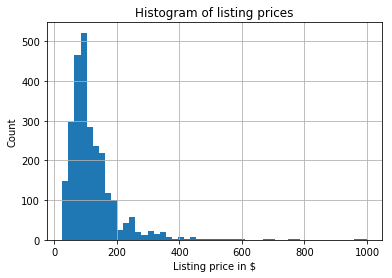

In [32]:
df_cleaned['price'].hist(bins=50);
plt.ylabel('Count');
plt.xlabel('Listing price in $');
plt.title('Histogram of listing prices');

**Observation:** It is a right skewed distribution. Most prices are within the range from 0 to 200. The most expensive listings almost reach 1000. 

In [33]:
# mode of price
df_cleaned['price'].mode()

0    150.0
dtype: float64

In [34]:
q_outlier = 0.99
df_cleaned['price'].quantile(q_outlier)

435.0

In [35]:
df_4_reg = df_cleaned[df_cleaned['price']<df_cleaned['price'].quantile(q_outlier)]

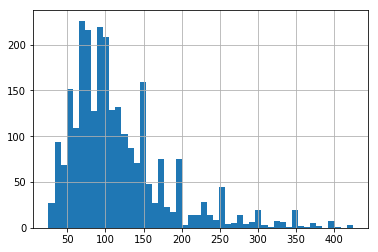

In [36]:
df_4_reg['price'].hist(bins=50);

## Step 4.3: Regression by machine learning
In this section, two kinds of regression algorithm are applied, linear regression model and random forest model. The results are evaluated by R2 score and mean square error.

In [37]:
X = df_4_reg.drop('price', axis=1, inplace=False)
y = df_4_reg['price'].reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


### Step 4.3.1 Linear regression model

In [38]:
lm_model = LinearRegression()
lm_model.fit(X_train,y_train)
y_train_pred = lm_model.predict(X_train)
y_test_pred = lm_model.predict(X_test)

In [39]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1315.307, test: 55733161759341867224268800.000
R^2 train: 0.688, test: -12414568999121368121344.000


**Observation:** the linear regression model did not work well. 

### Step 4.3.2 Random forest model

In [40]:
Rforest = RandomForestRegressor(n_estimators=200, 
                               random_state=1,
                               n_jobs=-1)
Rforest.fit(X_train, y_train)
y_train_pred = Rforest.predict(X_train).reshape(-1,1)
y_test_pred = Rforest.predict(X_test).reshape(-1,1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [41]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 170.646, test: 1546.774
R^2 train: 0.959, test: 0.655


### Step 4.3.3 Parameters tuning

The random forest model is selected for parameters tuning.

In [42]:
param_grid={'n_estimators':[50,100,200],
            'max_depth':[25,30,35], 
            'min_samples_leaf':[3,5], 
            #'max_features':[0.5],
            'random_state':[1],
            'n_jobs':[-1]}

In [43]:
grid_obj = GridSearchCV(RandomForestRegressor(),param_grid, scoring = 'r2')

In [44]:
grid_obj.fit(X_train, y_train)
best_r = grid_obj.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

In [45]:
best_predictions = best_r.predict(X_test).reshape(-1,1)
y_train_grid = best_r.predict(X_train).reshape(-1,1)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_grid),
        mean_squared_error(y_test, best_predictions)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_grid),
        r2_score(y_test, best_predictions)))
    

MSE train: 419.018, test: 1507.226
R^2 train: 0.900, test: 0.664


In [46]:
print (grid_obj.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


In [47]:
print (Rforest)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


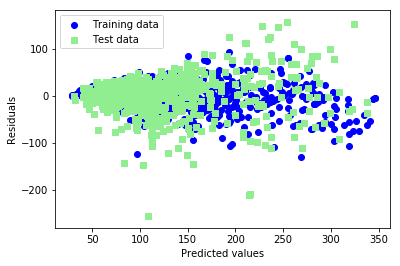

In [48]:
plt.scatter(y_train_grid, y_train_grid - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(best_predictions,  best_predictions - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

### Step 4.3.4 Feature importances
In this part, the two-5 importances of features when making predictions are ranked. 

In [49]:
# feature importances
importances = best_r.feature_importances_

In [50]:
def feature_plot(importances, X_train):
    """plot the feature importances of the top-5 most weighted features
    importances -- output of feature importances 
    X_train -- training dataset without label
    """
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,6))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns, rotation=20)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  

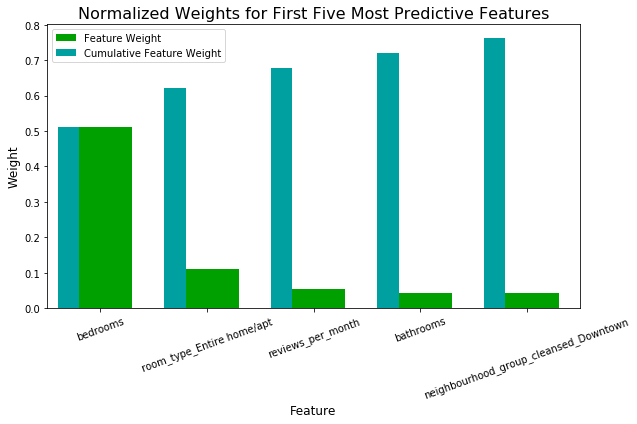

In [51]:
feature_plot(importances, X_train)